Implementing an Autoencoder in PyTorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The primary differences are that the network is much larger (as the code is designed to work with much larger images) and the model is split into two parts to allow for differential encode/decode metrics such as Mahalanobis Distance.

This version of the model is designed with a convolutional model.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import math
import numpy
import collections
import gc

from model import OldSplitAutoencoder,SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder
from CustomDataSet import CustomDataSet


from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
import os

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
#seed = 2662
#seed = 322

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
print(platform)

print("memory at beginning of run")
GPUtil.showUtilization()

cuda
memory at beginning of run
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [22]:
width = 256
height = 256

image_size = width * height

epochs = 150
learning_rate = 1e-5

batch_size = 4

#meta-parameters
l2_decays = [0.0]
dropout_rates = [0.0]
code_sides = [20]
code_size=400
convolution_filters = [32]

#image_count = 200
image_count = -1

validation_split = 0.90


## Dataset

Using a custom dataset class to load the images:

In [4]:
from torchvision.transforms import ToTensor,Normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/" + str(width)
train_dataset = CustomDataSet(root_dir, transform)

if (image_count == -1):
    train_dataset_subset = train_dataset
    image_count = len(train_dataset)
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

train_subset_idx = np.random.choice(len(train_dataset), int(image_count * validation_split), replace=False)

n = np.arange(len(train_dataset))
mask = np.ones(len(train_dataset), dtype=bool)
mask[train_subset_idx] = False
holdout_subset_idx = n[mask]


In [5]:
print(train_subset_idx)
print(holdout_subset_idx)
print(len(train_subset_idx))
print(len(holdout_subset_idx))

[ 260 2390 1927 ... 3299 3381 1702]
[   2    4   19   24   39   48   53   61   64   81   82  120  156  157
  168  176  181  182  199  203  226  230  232  245  246  264  294  300
  302  313  314  320  326  335  337  338  341  354  356  366  370  374
  386  394  400  415  420  425  426  439  464  471  486  487  489  491
  494  511  513  538  543  548  550  556  579  591  598  602  609  610
  615  625  640  646  652  667  688  712  733  752  767  778  780  788
  799  800  809  842  866  868  874  905  914  926  935  950  958  970
  971  972  974  982  991  994 1001 1002 1003 1007 1010 1023 1035 1040
 1049 1084 1114 1115 1120 1155 1167 1184 1194 1195 1235 1241 1244 1250
 1254 1267 1274 1294 1298 1326 1336 1344 1351 1375 1378 1398 1399 1400
 1401 1426 1446 1454 1456 1462 1477 1488 1490 1493 1495 1497 1507 1532
 1543 1544 1554 1557 1569 1589 1593 1599 1601 1602 1622 1632 1636 1639
 1640 1653 1657 1661 1678 1682 1684 1695 1703 1707 1716 1727 1732 1743
 1754 1757 1764 1767 1809 1811 1816 1817 

In [6]:
dataset_size = len(train_dataset_subset)
      
t_subset = torch.utils.data.Subset(train_dataset_subset, train_subset_idx)

train_loader = torch.utils.data.DataLoader(
    t_subset, batch_size=batch_size
)


In [7]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_device = torch.device(platform)
store_device = torch.device("cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu

models = []
optimizers = []

print("memory before model construction")
GPUtil.showUtilization()


for i in range(len(code_sides)):
    models.append([])
    optimizers.append([])
    code_size = code_sides[i] * code_sides[i]
    for j in range(len(convolution_filters)):
        filters =  convolution_filters[j]
        models[i].append([])
        optimizers[i].append([])
        for k in range(len(dropout_rates)):
            dropout_rate = dropout_rates[k]
            models[i][j].append([])
            optimizers[i][j].append([])
            for l in range(len(l2_decays)):
                l2_decay = l2_decays[l]
                #new_model = SplitAutoencoder(input_shape=(height,width),code_size=code_size,convolutions=filters,dropout_chance=dropout_rate).to(store_device)
                new_model = SplitAutoencoder(input_shape=(height,width),code_size=code_size).to(store_device)
                new_optimizer = optim.Adam(new_model.parameters(), weight_decay=l2_decay, lr=learning_rate)
                models[i][j][k].append(new_model)
                optimizers[i][j][k].append(new_optimizer)

print("memory after model construction")
GPUtil.showUtilization()
# mean-squared error loss
criterion = nn.MSELoss()

memory before model construction
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |
memory after model construction
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


We use a grid parameter search method to train our autoencoder for our specified number of epochs for each combination of code sizes and convolutional filters

In [8]:
best_model_dicts = []
# populate with fake best models
for i in range(len(code_sides)):
    best_model_dicts.append([])
    for j in range(len(convolution_filters)):
        best_model_dicts[i].append([])
        for k in range(len(dropout_rates)):
            best_model_dicts[i][j].append([])
            for l in range(len(l2_decays)):
                best_model_dicts[i][j][k].append((65535.0,None))
print(best_model_dicts)

[[[[(65535.0, None)]]]]


In [23]:
train_losses = []

batch_features_n = torch.empty(batch_size, 1, width, height, dtype=torch.float32)
for i in range(len(code_sides)):
    train_losses.append([])
    for j in range(len(convolution_filters)):
        train_losses[i].append([])
        for k in range(len(dropout_rates)):
            train_losses[i][j].append([])
            for l in range(len(l2_decays)):
                early_stopping_hits = 0
                train_losses[i][j][k].append([])
                print("==================")
                print("Running for code size:" + str(code_sides[i] * code_sides[i]) + ", filter size:"+str(convolution_filters[j]) + " with L2/dropout:" + str(l2_decays[l]) + "/" + str(dropout_rates[k]))
                try:
                    model_n = models[i][j][k][l].to(run_device)
                    if torch.cuda.device_count() > 1:
                        model_n = nn.DataParallel(model_n)
                    optimo = optimizers[i][j][k][l]
                    for epoch in range(epochs):
                        model_n.train()  # Set model to training mode
                        epoch_loss = 0.0
                        for batch_features in train_loader:
                            # load it to the active device
                            batch_features_n = batch_features.to(run_device)

                            # reset the gradients back to zero
                            # PyTorch accumulates gradients on subsequent backward passes
                            optimo.zero_grad()

                            # compute reconstructions
                            codes = model_n.encoder(batch_features_n)
                            outputs = model_n.decoder(codes)

                            # compute training reconstruction loss
                            local_losses = criterion(outputs,batch_features_n)

                            #penalise any all-black outputs
                            #for ind in range(len(local_losses)):
                            #    if(torch.sum(outputs[ind]) == 0.0):
                            #        local_losses[ind] = local_losses[ind] * 2

                            #calculate mean batch loss (including all-black penalty)
                            local_loss = torch.mean(local_losses)
                           
                            # compute accumulated gradients
                            local_losses.backward()

                            # perform parameter update based on current gradients
                            optimo.step()

                            # add the mini-batch training loss to epoch loss
                            epoch_loss += local_loss.item()

                            del local_loss
                            del codes
                            del outputs


                        # compute the epoch training loss

                        epoch_loss = epoch_loss / len(train_loader)

                        #check if best model
                        if(epoch_loss < best_model_dicts[i][j][k][l][0]):
                            print("new best!")
                            model_dict = {}
                            for key, v in model_n.state_dict().items():
                                  model_dict[key] = v.cpu()
                            best_model_dicts[i][j][k][l] = (epoch_loss,model_dict)

                        train_losses[i][j][k][l].append(epoch)

                        # display the epoch training loss
                        print("epoch : {}/{}, train loss = {:.8f}".format(epoch + 1, epochs, epoch_loss))

                    del model_n
                    del optimo
                    torch.cuda.empty_cache()
                except RuntimeError as e:
                    print("Can't complete this model due to:" + str(e))
                    model_n = None
                    optimo = None

                print("Memory at model end")
                GPUtil.showUtilization()

print('\a')

Running for code size:400, filter size:32 with L2/dropout:0.0/0.0
epoch : 1/150, train loss = 0.00154807
epoch : 2/150, train loss = 0.00153587
new best!
epoch : 3/150, train loss = 0.00153066
new best!
epoch : 4/150, train loss = 0.00152916
epoch : 5/150, train loss = 0.00153126
epoch : 6/150, train loss = 0.00153762
epoch : 7/150, train loss = 0.00155240
epoch : 8/150, train loss = 0.00158094
epoch : 9/150, train loss = 0.00160365
epoch : 10/150, train loss = 0.00159247
epoch : 11/150, train loss = 0.00156020
epoch : 12/150, train loss = 0.00153064
new best!
epoch : 13/150, train loss = 0.00151120
new best!
epoch : 14/150, train loss = 0.00150287
epoch : 15/150, train loss = 0.00150514
epoch : 16/150, train loss = 0.00151482
epoch : 17/150, train loss = 0.00152568
epoch : 18/150, train loss = 0.00153554
epoch : 19/150, train loss = 0.00153531
epoch : 20/150, train loss = 0.00152272
epoch : 21/150, train loss = 0.00150798
epoch : 22/150, train loss = 0.00150306
epoch : 23/150, train l

Restore the best trained model and save.

In [24]:
print("memory before model restoration")
GPUtil.showUtilization()
#print(best_model_dicts)
for i in range(len(code_sides)):
    for j in range(len(convolution_filters)):
        for k in range(len(dropout_rates)):
            for l in range(len(l2_decays)):
                if(best_model_dicts[i][j][k][l][1]!=None):
                    print("Restoring best model for "+ str(i) + "/" + str(j) + "/" + str(k) + "/" + str(l));
                    models[i][j][k][l].load_state_dict(best_model_dicts[i][j][k][l][1], )
                    PATH = "../../Data/OPTIMAM_NEW/model" + str(width) + "_" + str(code_sides[i]) + "_" + str(convolution_filters[j]) + "_" + str(dropout_rates[k]) + "_" + str(l2_decays[l]) + ".pt"
                    torch.save(models[i][j][k][l], PATH)

print("memory after model restoration")
GPUtil.showUtilization()

memory before model restoration
| ID | GPU | MEM |
------------------
|  0 | 91% | 63% |
Restoring best model for 0/0/0/0
memory after model restoration
| ID | GPU | MEM |
------------------
|  0 |  0% | 63% |


Let's extract some test examples to reconstruct using our trained autoencoder.

In [25]:
v_subset = torch.utils.data.Subset(train_dataset_subset, holdout_subset_idx)

test_loader = torch.utils.data.DataLoader(
    t_subset, batch_size=5, shuffle=True
)

test_example_sets = []
code_sets = []
reconstruction_sets = []

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

In [26]:
print("memory before testing")
GPUtil.showUtilization()
with torch.no_grad():
    for i in range(len(code_sides)):
        test_example_sets.append([])
        code_sets.append([])
        reconstruction_sets.append([])
        
        for j in range(len(convolution_filters)):
            test_example_sets[i].append([])
            code_sets[i].append([])
            reconstruction_sets[i].append([])
            for k in range(len(dropout_rates)):
                test_example_sets[i][j].append([None] * len(l2_decays))
                code_sets[i][j].append([None] * len(l2_decays))
                reconstruction_sets[i][j].append([None] * len(l2_decays))
                for l in range(len(l2_decays)):
                    if(best_model_dicts[i][j][k][l][1]!=None):
                        model_t = models[i][j][k][l].to(run_device)
                        for batch_features in test_loader:
                            test_examples = batch_features.to(run_device)
                            n_codes = model_t.encoder(test_examples)
                            reconstruction = model_t.decoder(n_codes)
                            break;
                        test_example_sets[i][j][k][l] = test_examples.to(store_device)
                        code_sets[i][j][k][l] = n_codes.to(store_device)
                        reconstruction_sets[i][j][k][l] = reconstruction.to(store_device)
                        del test_examples
                        del n_codes
                        del reconstruction
print("memory after testing")
GPUtil.showUtilization()

memory before testing
| ID | GPU | MEM |
------------------
|  0 |  0% | 63% |
memory after testing
| ID | GPU | MEM |
------------------
|  0 |  1% | 64% |


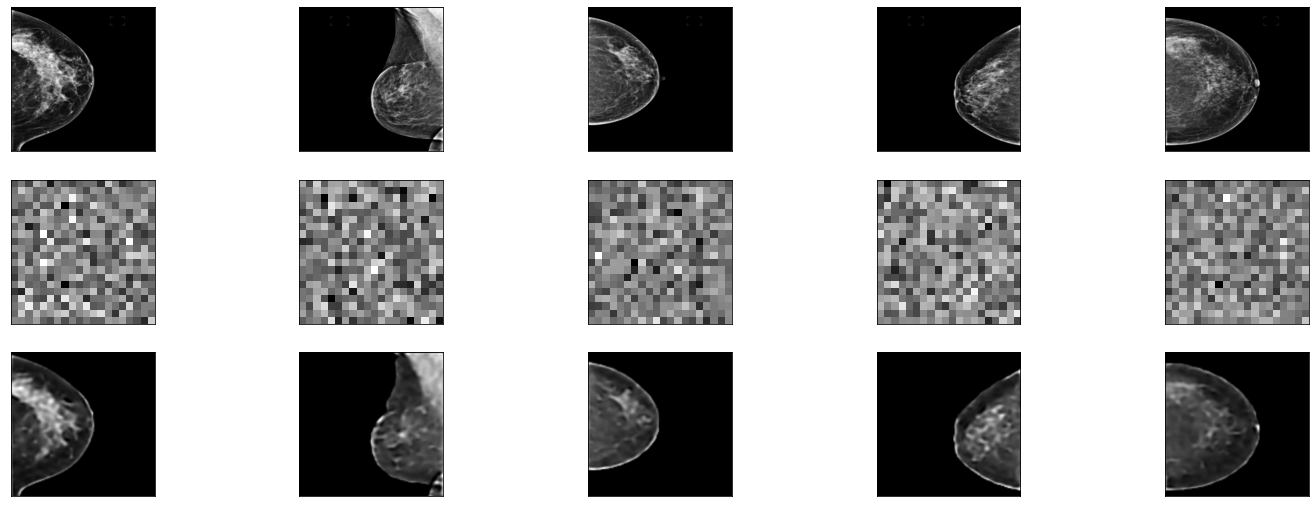

In [27]:
with torch.no_grad():
    for i in range(len(code_sides)):
        for j in range(len(convolution_filters)):
            for k in range(len(dropout_rates)):
                for l in range(len(l2_decays)):
                    if(best_model_dicts[i][j][k][l][1]!=None):
                        number = 5
                        plt.figure(figsize=(25, 9))
                        for index in range(number):
                            # display original
                            ax = plt.subplot(3, number, index + 1)
                            test_examples = test_example_sets[i][j][k][l]
                            copyback = test_examples[index].cpu()
                            #plt.imshow(copyback.numpy().reshape(height, width), vmin=0, vmax=65535)
                            plt.imshow(copyback.reshape(height, width))
                            plt.gray()
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)

                            # display codes
                            ax = plt.subplot(3, number, index + 1 + number)
                            codes = code_sets[i][j][k][l]
                            code_copyback = codes[index].cpu()
                            plt.imshow(code_copyback.numpy().reshape(code_sides[i],code_sides[i]))
                            plt.gray()
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)

                            # display reconstruction
                            ax = plt.subplot(3, number, index + 6 + number)
                            reconstruction = reconstruction_sets[i][j][k][l]
                            recon_copyback = reconstruction[index].cpu()
                            plt.imshow(recon_copyback.reshape(height, width))
                            plt.gray()
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)

                        out_path = "output"+ str(width) + "_"  + str(code_sides[i]) + "_" + str(convolution_filters[j]) + "_" + str(dropout_rates[k]) + "_" + str(l2_decays[l]) +".png" 
                        plt.savefig(out_path)
                        #plt.show()

In [28]:
from quickemail import SendEmail
SendEmail("Run Completed","The new autoencoder run is complete", "wgr@aber.ac.uk")

email sent
